In [44]:
import pandas, numpy, warnings, matplotlib.pyplot as plot
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Ridge

random_state = 42
numpy.random.seed(random_state) 
label_name = 'Life ladder'
pandas.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

training_data = pandas.read_csv('data/train.csv')
testing_data = pandas.read_csv('data/test.csv')

preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())               
])

label_key = 'Life ladder'
alphas = [0.001, 0.005, 0.1]
eta0s = [0.001, 0.005, 0.01]
degrees = [1,2,3,4]
penalties = ['l2', 'l1', 'elasticnet']
cross_validator  = KFold(n_splits=4, shuffle=True, random_state=random_state)


In [45]:
features_training = training_data.drop(label_name, axis=1)
label_training = training_data[label_name]

# **Closed-Form Solution**

In [46]:
ridge_pipeline = Pipeline(
    steps = preprocessing_pipeline.steps + [
        ('poly', PolynomialFeatures(3, include_bias=False)),
        ('model', Ridge(100))
    ]
)

ridge_pipeline.fit(features_training, label_training)

print(f'RMSE using Ridge (Closed Form): {root_mean_squared_error(label_training, ridge_pipeline.predict(features_training))}')

RMSE using Ridge (Closed Form): 0.45564558823003676


# **SGD (Stochastic Gradient Descent) Regressor**

## **Optimal Hyperparameters**

In [47]:
results = []

for degree in degrees:
    for penalty in penalties:
        for alpha in alphas:
            for eta0 in eta0s:
                sgd_pipeline = Pipeline(
                    steps = preprocessing_pipeline.steps + [
                        ('poly', PolynomialFeatures(degree, include_bias=False)),
                        (
                            'model', SGDRegressor
                            (
                                penalty=penalty,
                                alpha=alpha,
                                eta0=eta0,
                                learning_rate='constant',
                                shuffle=True,
                                max_iter=5000,  
                                tol=1e-4,
                                random_state=random_state
                            )
                        )
                    ]
                )
                rmse_values = -cross_val_score(sgd_pipeline, features_training, label_training, cv=cross_validator , scoring='neg_root_mean_squared_error')
                
                results.append({
                    'Penalty': penalty,
                    'Alpha': alpha,
                    'Learning Rate': eta0,
                    'Mean RMSE': rmse_values.mean(),
                    'Standard Deviation of RMSE':  rmse_values.std(),
                    'Degree': degree
                })
            
results = pandas.DataFrame(results).sort_values('Mean RMSE').reset_index(drop=True)
optimal_configuration = results.iloc[0]

display(results)
print(optimal_configuration)

,Penalty,Alpha,Learning Rate,Mean RMSE,Standard Deviation of RMSE,Degree
0,l1,0.0050,0.0010,0.5120,0.0268,2
1,l2,0.1000,0.0010,0.5155,0.0275,2
2,elasticnet,0.0050,0.0010,0.5178,0.0254,2
3,l1,0.0010,0.0010,0.5180,0.0254,2
4,elasticnet,0.1000,0.0050,0.5204,0.0267,2
...,...,...,...,...,...,...
103,l1,0.0010,0.0100,131886251943397.8594,33757605240950.2773,4
104,l2,0.0050,0.0100,134239495598935.8125,56467769110674.8125,4
105,l2,0.0010,0.0100,142642090027953.7812,20303545449246.2109,4
106,elasticnet,0.0050,0.0100,149653693133304.7188,36446577157821.0078,4


Penalty                          l1
Alpha                        0.0050
Learning Rate                0.0010
Mean RMSE                    0.5120
Standard Deviation of RMSE   0.0268
Degree                            2
Name: 0, dtype: object


In [48]:
pipeline = Pipeline(
    steps=preprocessing_pipeline.steps + [
        ('poly', PolynomialFeatures(optimal_configuration['Degree'], include_bias=False)),
        ('model', SGDRegressor(
            penalty=optimal_configuration['Penalty'],
            alpha=optimal_configuration['Alpha'],
            eta0=optimal_configuration['Learning Rate'],
            learning_rate='adaptive',        
            random_state=random_state,
            max_iter=5000,
            tol=1e-4,
            shuffle=True
        ))
    ]
)

rmse_values = -cross_val_score(
                pipeline, 
                features_training, 
                label_training, 
                cv=cross_validator, 
                scoring='neg_root_mean_squared_error'
            )

print(f'RMSE Values: {numpy.round(rmse_values, 4)}')
print(f'Mean RMSE: {rmse_values.mean():{'.4f'}}')
print(f'Standard Deviation of RMSE: {rmse_values.std():{'.4f'}}')

RMSE Values: [0.5596 0.4973 0.4913 0.495 ]
Mean RMSE: 0.5108
Standard Deviation of RMSE: 0.0283


# **RMSE over Polynomial Degree**

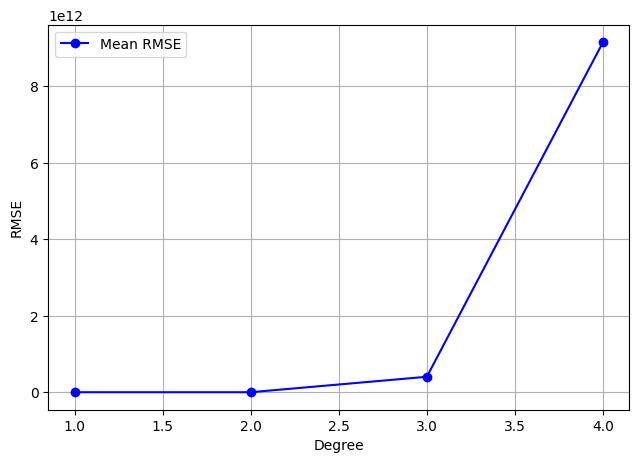

In [49]:
aggregated_results = results.groupby('Degree')['Mean RMSE'].min().reset_index()

plot.figure(figsize=(7.5, 5))
plot.plot(aggregated_results['Degree'], aggregated_results['Mean RMSE'], marker='o', linestyle='-', color='b', label='Mean RMSE')
plot.xlabel('Degree')
plot.ylabel('RMSE')
plot.grid(True)
plot.legend()
plot.show()

# **Training and Validation Loss Over Epochs**

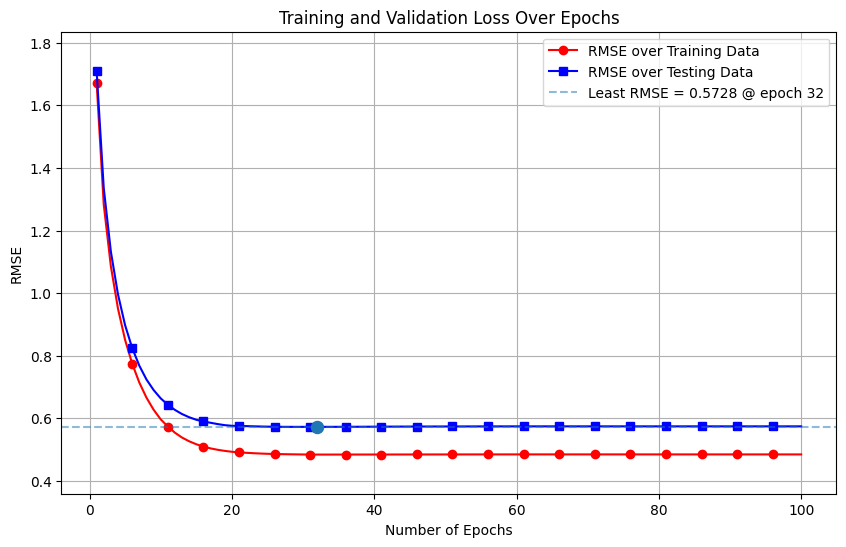

In [50]:
X_training, X_testing, y_training, y_testing = train_test_split(
    features_training, label_training, test_size=0.2, random_state=random_state
)

sgd_pipeline = Pipeline(
    steps=preprocessing_pipeline.steps + [
        ('poly', PolynomialFeatures(optimal_configuration['Degree'], include_bias=False)),
        ('model', SGDRegressor(
            penalty=optimal_configuration['Penalty'],
            alpha=optimal_configuration['Alpha'],
            eta0=optimal_configuration['Learning Rate'],
            learning_rate='constant',
            shuffle=True,
            tol=None,
            max_iter=1, 
            warm_start=True,
            random_state=random_state
        ))
    ]
)

errors_training, errors_testing = [], []
least_rmse = float('inf')
minimum_epochs = None
epochs_count = 100

for epoch in range(1, epochs_count + 1):
    sgd_pipeline.fit(X_training, y_training)
    
    predictions_training = sgd_pipeline.predict(X_training)
    predictions_testing = sgd_pipeline.predict(X_testing)
    
    error_training = root_mean_squared_error(y_training, predictions_training)
    error_testing = root_mean_squared_error(y_testing, predictions_testing)
    
    errors_training.append(error_training)
    errors_testing.append(error_testing)
    
    if error_testing < least_rmse:
        least_rmse, minimum_epochs = error_testing, epoch

plot.figure(figsize=(10, 6))
x_axis = range(1, epochs_count + 1)
plot.plot(x_axis, errors_training, 'r-', marker='o', markevery=5, label='RMSE over Training Data')
plot.plot(x_axis, errors_testing, 'b-', marker='s', markevery=5, label='RMSE over Testing Data')

buffer = 0.125
plot.ylim(min(errors_training + errors_testing) - buffer, max(errors_training + errors_testing) + buffer)

plot.axhline(least_rmse, ls='--', alpha=0.5, label=f'Least RMSE = {least_rmse:.4f} @ epoch {minimum_epochs}')
plot.scatter([minimum_epochs], [least_rmse], s=75, zorder=2)

plot.xlabel('Number of Epochs')
plot.ylabel('RMSE')
plot.title('Training and Validation Loss Over Epochs')
plot.grid(True)
plot.legend()
plot.show()


# **Test Data Evaluation**

In [51]:
features_testing = testing_data.drop(label_key, axis=1)
label_testing = testing_data[label_key]

sgd_pipeline = Pipeline(
    steps=preprocessing_pipeline.steps + [
        ('poly', PolynomialFeatures(optimal_configuration['Degree'], include_bias=False)),
        ('model', SGDRegressor(
            penalty=optimal_configuration['Penalty'],
            alpha=optimal_configuration['Alpha'],
            eta0=optimal_configuration['Learning Rate'],
            learning_rate='adaptive',        
            random_state=random_state,
            max_iter=5000,
            tol=1e-4,
            shuffle=True
        ))
    ]
)

ridge_pipeline = Pipeline(
    steps=preprocessing_pipeline.steps + [
        ('poly', PolynomialFeatures(3, include_bias=False)),
        ('model', Ridge(100))
    ]
)

sgd_pipeline.fit(features_training, label_training)
ridge_pipeline.fit(features_training, label_training)

print(f'RMSE using SGD: {root_mean_squared_error(label_testing, sgd_pipeline.predict(features_testing))}')
print(f'RMSE using Ridge (Closed Form): {root_mean_squared_error(label_testing, ridge_pipeline.predict(features_testing))}')

RMSE using SGD: 0.5102099603121344
RMSE using Ridge (Closed Form): 0.5013562419649283
